In [1]:
# making the data ready
from sklearn.datasets import make_circles

#make 1000 samples
n_sampples = 1000

X, y = make_circles(n_samples=n_sampples,
                   noise=0.03,  # a little bit of noise to the dots
                   random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# now we visualize the data using dataframe

import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# check how many values of each class
circles.label.value_counts()

,count
label,
1,500
0,500


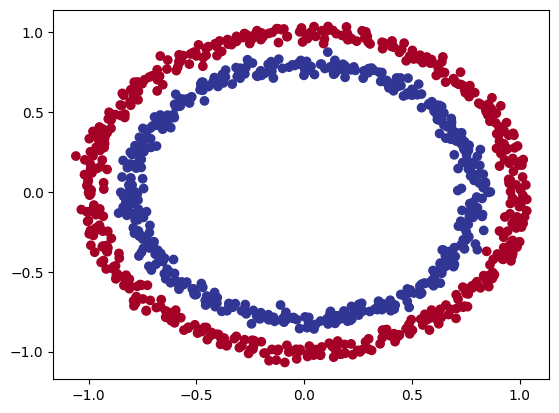

In [5]:
# lets visualize the values by plotting them

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);


In [6]:
# lets find the shapes of the input and output data
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
# converting the data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# view five samples of each
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# lets split the data into train and test splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
# building the model for classification

import torch
from torch import nn

# device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
# creating the nn module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2 , out_features = 10) # takes in 2 features and generates 10 features
        self.layer_2 = nn.Linear(in_features = 10 , out_features = 10) # takes in 10 features and generates 5 features
        self.layer_3 = nn.Linear(in_features = 10 , out_features = 1) # takes 5 feeatures and generates 1 feature
        self.relu = nn.ReLU() # activation function

    # forward pass
    def forward(self,x):
      return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

# create the instance of the model and send it to device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [13]:
# replicating the forward path with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features = 2 , out_features =10),
    nn.Linear(in_features = 10 , out_features= 10),
    nn.Linear(in_features = 10 , out_features = 1)
).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1298],
        [ 0.1561],
        [ 0.1056],
        [ 0.1673],
        [-0.0427],
        [-0.0236],
        [ 0.0874],
        [ 0.0498],
        [ 0.1133],
        [ 0.1566]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [26]:
# loss function

loss_fn = nn.BCEWithLogitsLoss()

# optimizer

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


In [15]:
# find accuracy of the model

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [28]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1298],
        [ 0.1561],
        [ 0.1056],
        [ 0.1673],
        [-0.0427]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5348],
        [0.5361],
        [0.5084],
        [0.5424],
        [0.4719]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [29]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

In [31]:
# training loop

torch.manual_seed(42)

# we put model data to device

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

# set the number of epochs
epochs = 1000

for epoch in range(epochs):
    model_0.train()

  # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

  # 2. calculate the loss and accuracy
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  # optimizer zero grad
    optimizer.zero_grad()

  # calculate backward propogation
    loss.backward()

  # optimizer step
    optimizer.step()

  # testing the model

  # set model to evaluation mode
    model_0.eval()

  # predictions
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculates test loss and test accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

  # print whats happening after 10 epochs
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69833 | Acc: 50.00% | Test Loss: 0.69863 | Test Acc: 49.00%
Epoch: 100 | Loss: 0.69289 | Acc: 50.88% | Test Loss: 0.69411 | Test Acc: 47.00%
Epoch: 200 | Loss: 0.69015 | Acc: 53.37% | Test Loss: 0.69141 | Test Acc: 50.00%
Epoch: 300 | Loss: 0.68762 | Acc: 56.62% | Test Loss: 0.68828 | Test Acc: 55.00%
Epoch: 400 | Loss: 0.68469 | Acc: 60.00% | Test Loss: 0.68469 | Test Acc: 61.00%
Epoch: 500 | Loss: 0.67985 | Acc: 56.00% | Test Loss: 0.67890 | Test Acc: 60.50%
Epoch: 600 | Loss: 0.67280 | Acc: 56.00% | Test Loss: 0.67176 | Test Acc: 60.50%
Epoch: 700 | Loss: 0.66304 | Acc: 64.50% | Test Loss: 0.66452 | Test Acc: 65.00%
Epoch: 800 | Loss: 0.64710 | Acc: 74.12% | Test Loss: 0.65300 | Test Acc: 71.50%
Epoch: 900 | Loss: 0.62182 | Acc: 81.62% | Test Loss: 0.63241 | Test Acc: 78.00%


In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

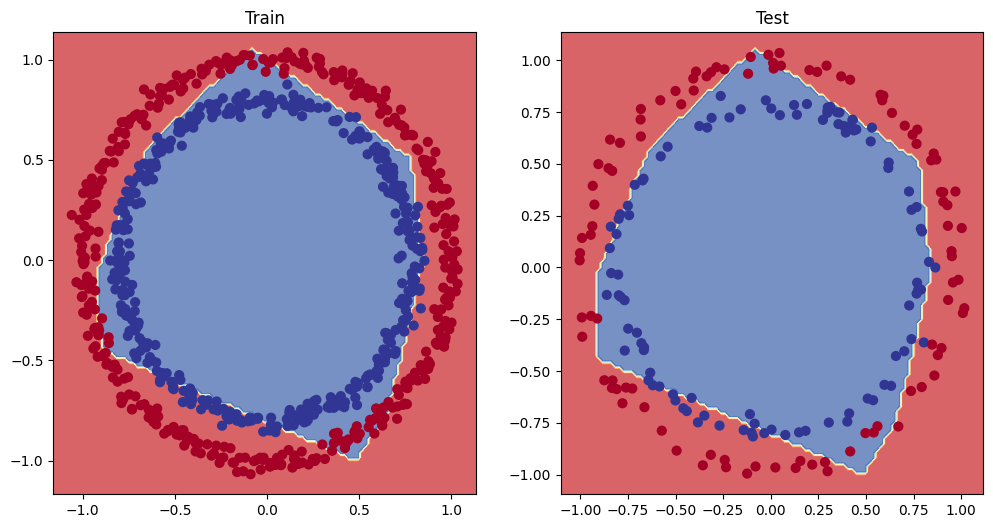

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [1]:
#### Multiclass classification

import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# makde code device agnostic

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3., 2., 2., 1., 1.])


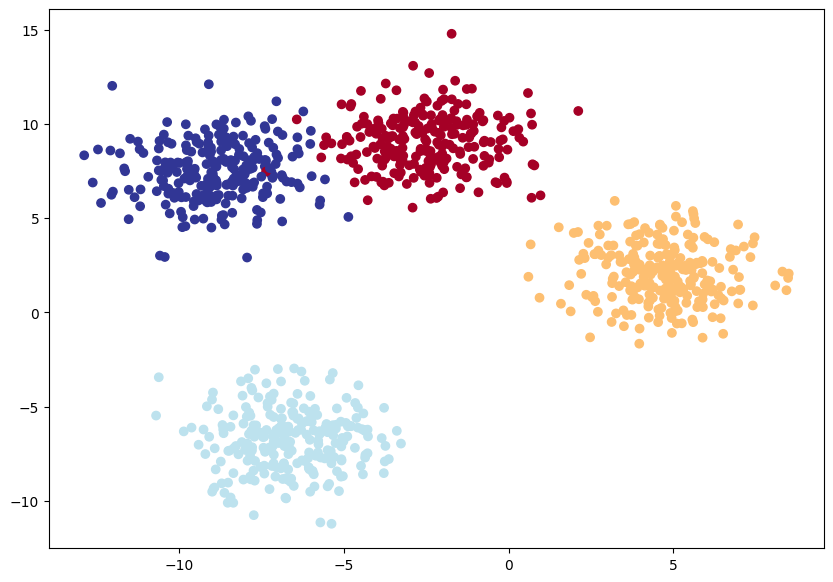

In [2]:


# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create a multi class data
X_blob , y_blob = make_blobs(n_samples=1000,
                              n_features=NUM_FEATURES,
                              centers=NUM_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

# convert the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

print(X_blob[:5], y_blob[:5])

# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size= 0.2, random_state= RANDOM_SEED)


# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
# model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# loss function

loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)

In [5]:
model_4(X_train.to(device))[:5]

tensor([[ 1.0554,  0.5852, -1.5390,  1.1342],
        [ 2.5404,  0.5409, -0.7389,  0.6595],
        [-1.2341,  0.3271,  2.4617, -2.5941],
        [-0.3221,  0.3926,  1.4672, -1.6195],
        [ 2.0706,  0.5146, -0.3446,  0.2580]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [6]:
model_4(X_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [7]:
# Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.3125,  0.5898, -1.5973,  1.2197],
        [ 2.1063,  0.4560,  0.5971, -0.5395],
        [-1.0364,  0.3632,  1.8950, -2.0837],
        [ 0.6378,  0.5525, -1.0396,  0.6504],
        [ 2.6181,  0.5757, -1.2921,  1.1417]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4079, 0.1980, 0.0222, 0.3718],
        [0.6738, 0.1294, 0.1490, 0.0478],
        [0.0414, 0.1678, 0.7763, 0.0145],
        [0.3207, 0.2945, 0.0599, 0.3248],
        [0.7256, 0.0941, 0.0145, 0.1658]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [9]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4079, 0.1980, 0.0222, 0.3718], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [16]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train.type(torch.long))
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test.type(torch.long))
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.29057, Acc: 50.88% | Test Loss: 0.74476, Test Acc: 71.50%
Epoch: 10 | Loss: 0.17119, Acc: 99.25% | Test Loss: 0.15537, Test Acc: 99.50%
Epoch: 20 | Loss: 0.09163, Acc: 99.12% | Test Loss: 0.08289, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06536, Acc: 99.12% | Test Loss: 0.05741, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05300, Acc: 99.12% | Test Loss: 0.04505, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04598, Acc: 99.12% | Test Loss: 0.03788, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04151, Acc: 99.12% | Test Loss: 0.03325, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03845, Acc: 99.12% | Test Loss: 0.03001, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03623, Acc: 99.12% | Test Loss: 0.02764, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03456, Acc: 99.12% | Test Loss: 0.02582, Test Acc: 99.50%


In [18]:
 # Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  7.9508,  13.3755, -11.0899,  -5.5268],
        [  3.3000, -11.9362,   1.4697,   8.9020],
        [-11.4827, -17.4265,  15.7250,   7.4072],
        [  3.8497,   9.2437,  -6.2419,  -4.2935],
        [ 11.2854,   6.7185, -11.6023,  -0.2017],
        [  3.3519, -15.0497,   2.4922,  10.8864],
        [-11.2232, -13.9710,  14.3247,   5.3113],
        [  8.9175,   1.7173,  -7.9077,   2.1627],
        [-12.7950, -23.4272,  18.8782,  10.7574],
        [  9.6114,   3.4971,  -9.0979,   1.2713]], device='cuda:0')

In [19]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.], device='cuda:0')
Test accuracy: 99.5%


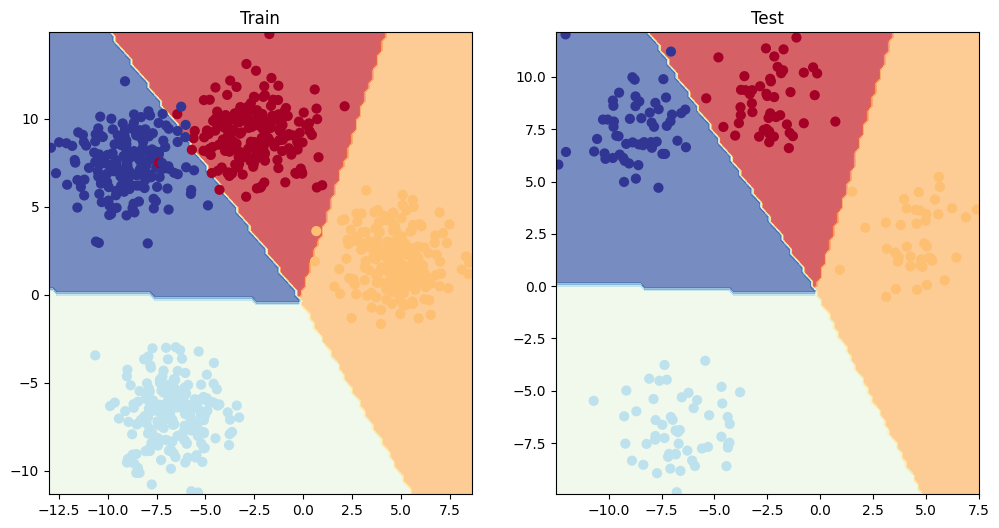

In [23]:


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)